<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span>

# Отток клиентов

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
data.info()
data['Tenure'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [4]:
data.dropna(inplace=True)

In [5]:
data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1, inplace=True)


In [6]:
data_ohe = pd.get_dummies(data, columns=['Geography', 'Gender',\
                               'HasCrCard', 'IsActiveMember'],  drop_first=True) 

In [7]:
data_train, data_test = train_test_split(data_ohe, train_size=0.6, random_state=12345, stratify=data_ohe['Exited'])
data_test, data_valid = train_test_split(data_test, train_size=0.5, random_state=12345, stratify=data_test['Exited'])

In [8]:
features_train = data_train.drop('Exited', axis=1)
target_train = data_train['Exited']

features_test = data_test.drop('Exited', axis=1)
target_test = data_test['Exited']

features_valid = data_valid.drop('Exited', axis=1)
target_valid = data_valid['Exited']

In [9]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(features_valid.shape)
print(target_valid.shape)

(5454, 11)
(5454,)
(1818, 11)
(1818,)
(1819, 11)
(1819,)


In [10]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', \
           'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Исследование задачи

In [11]:
display(data['Exited'].value_counts())

0    7237
1    1854
Name: Exited, dtype: int64

<div>
    <font color='green'>Модель решающего леса с дисбалансом</font>
</div>

100%|██████████| 39/39 [00:01<00:00, 30.62it/s]


max_depth лучшей модели: 7
f1 лучшей модели: 0.557659208261618


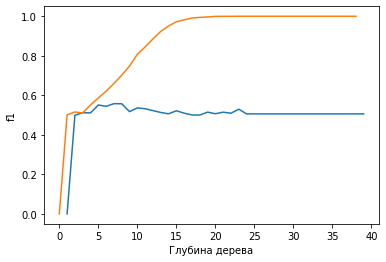

In [12]:
best_model_dt = None
best_result_dt = 0
result_dt_plot = []
result_dt_plot_train = []
for depth_dt in tqdm(range(1, 40)):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth_dt) 
    model_dt.fit(features_train, target_train) 
    predictions = model_dt.predict(features_valid) 
    result_dt = f1_score(target_valid, predictions) 
    result_dt_plot.append(result_dt)
    predictions_train = model_dt.predict(features_train) 
    result_dt_train = f1_score(target_train, predictions_train) 
    result_dt_plot_train.append(result_dt_train)
    if result_dt > best_result_dt:
        best_model_dt = model_dt
        best_result_dt = result_dt
        best_depth_dt = depth_dt

print('max_depth лучшей модели:', best_depth_dt)
print("f1 лучшей модели:", best_result_dt)

plt.plot(range(1,40), result_dt_plot, result_dt_plot_train)
plt.xlabel('Глубина дерева')
plt.ylabel('f1')
plt.show()

,feature,importance
0,Age,0.371957
1,NumOfProducts,0.266832
2,Balance,0.140401
3,IsActiveMember_1,0.113420
4,Geography_Germany,0.042242
5,EstimatedSalary,0.027038
6,CreditScore,0.021131
7,Tenure,0.008183
8,Gender_Male,0.003191
9,HasCrCard_1,0.003098


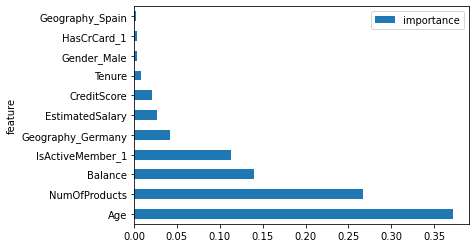

In [13]:
importances = best_model_dt.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).\
reset_index(drop=True)
display(feature_results.head(10))
feature_results.plot(kind='barh', x='feature')
plt.show()

<div>
    <font color='green'>AUC-ROC для модели решающего дерева с дисбалансом</font>
</div>

In [14]:
probabilities_valid = best_model_dt.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)# < напишите код здесь >

print(auc_roc)

0.8173603148128844


<div>
    <font color='green'>Модель случайного леса с дисбалансом</font>
</div>

In [15]:
best_model_rf = None
best_result_rf = 0
for depth_rf in tqdm(range(1, 40)):
    model_rf = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=depth_rf)  
    model_rf.fit(features_train, target_train)
    predictions = model_rf.predict(features_valid) 
    result_rf = f1_score(target_valid, predictions)  
    if result_rf > best_result_rf:
        best_model_rf = model_rf
        best_result_rf = result_rf
        best_depth_rf = depth_rf
print('max_depth лучшей модели:', best_depth_rf)
print("f1 наилучшей модели на валидационной выборке:", best_result_rf)

100%|██████████| 39/39 [00:15<00:00,  2.45it/s]

max_depth лучшей модели: 20
f1 наилучшей модели на валидационной выборке: 0.5856905158069883


,feature,importance
0,Age,0.238981
1,EstimatedSalary,0.147611
2,Balance,0.143929
3,CreditScore,0.141429
4,NumOfProducts,0.131169
5,Tenure,0.082665
6,IsActiveMember_1,0.035488
7,Geography_Germany,0.025505
8,Gender_Male,0.020616
9,HasCrCard_1,0.018952


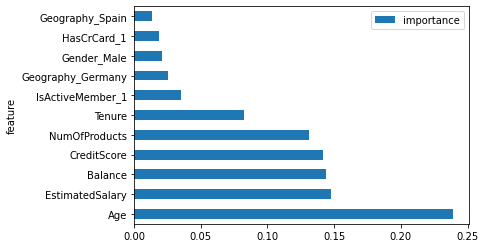

In [16]:
importances = best_model_rf.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).\
reset_index(drop=True)
display(feature_results.head(10))
feature_results.plot(kind='barh', x='feature')
plt.show()

<div>
    <font color='green'>AUC-ROC для модели случайного леса с дисбалансом</font>
</div>

In [17]:
probabilities_valid = best_model_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)# < напишите код здесь >

print(auc_roc)

0.837210168128546


<div>
    <font color='green'>Модель логистической регрессии с дисбалансом</font>
</div>

In [18]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear')

model_lr.fit(features_train, target_train)
predictions = model_lr.predict(features_valid) 
result_lr = f1_score(target_valid, predictions)

print('f1 модели:', result_lr)

f1 модели: 0.35203094777562866


<div>
    <font color='green'>AUC-ROC для модели логистической регрессии с дисбалансом</font>
</div>

In [19]:
probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)# < напишите код здесь >

print(auc_roc)

0.7743592798320205


Вывод:\
\
С дисбалансом не вышло необходимого значения f1 меры больше 0.59. Худшие результаты показала логистическая регрессия. Значение AUC-ROC у всех моделей около 0.8. Самым важным признаком для обучения у трёх моделей оказался признак Age.

## Борьба с дисбалансом

<div>
    <font color='green'>Модель решающего дерева с взешиванием классов</font>
</div>

100%|██████████| 39/39 [00:01<00:00, 28.01it/s]


max_depth лучшей модели: 8
f1 лучшей модели: 0.5665914221218962


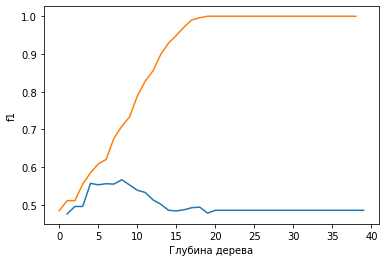

In [20]:
best_model_balance_dt = None
best_result_balance_dt = 0
result_dt_balance_plot = []
result_dt_balance_plot_train = []
for depth_dt in tqdm(range(1, 40)):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth_dt,\
                                      class_weight='balanced') 
    model_dt.fit(features_train, target_train) 
    predictions = model_dt.predict(features_valid) 
    result_dt = f1_score(target_valid, predictions) 
    result_dt_balance_plot.append(result_dt)
    predictions_train = model_dt.predict(features_train) 
    result_dt_train = f1_score(target_train, predictions_train) 
    result_dt_balance_plot_train.append(result_dt_train)
    if result_dt > best_result_balance_dt:
        best_model_balance_dt = model_dt
        best_result_balance_dt = result_dt
        best_depth_balance_dt = depth_dt

print('max_depth лучшей модели:', best_depth_balance_dt)
print("f1 лучшей модели:", best_result_balance_dt)

plt.plot(range(1,40), result_dt_balance_plot, result_dt_balance_plot_train)
plt.xlabel('Глубина дерева')
plt.ylabel('f1')
plt.show()

,feature,importance
0,Age,0.367349
1,NumOfProducts,0.258810
2,Balance,0.139124
3,EstimatedSalary,0.055996
4,CreditScore,0.049448
5,IsActiveMember_1,0.049418
6,Geography_Germany,0.032154
7,Tenure,0.021540
8,Gender_Male,0.018813
9,HasCrCard_1,0.005217


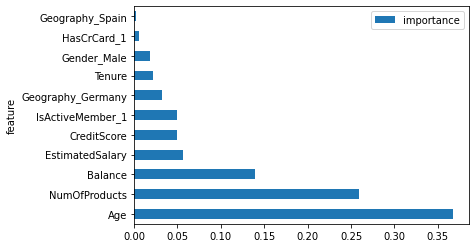

In [21]:
importances = best_model_balance_dt.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).\
reset_index(drop=True)
display(feature_results.head(10))
feature_results.plot(kind='barh', x='feature')
plt.show()

<div>
    <font color='green'>AUC-ROC для модели решающего дерева с взвешиванием классов</font>
</div>

In [22]:
probabilities_valid = best_model_balance_dt.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)# < напишите код здесь >

print(auc_roc)

0.8031311894089439


<div>
    <font color='green'>Модель случайного леса с взвешиванием классов</font>
</div>

In [23]:
best_model_balance_rf = None
best_result_balance_rf = 0
for depth_rf in tqdm(range(1, 20)):
    model_rf = RandomForestClassifier(random_state=12345, n_estimators=20, \
                                      max_depth=depth_rf, class_weight='balanced')  
    model_rf.fit(features_train, target_train)
    predictions = model_rf.predict(features_valid) 
    result_rf = f1_score(target_valid, predictions)  
    if result_rf > best_result_balance_rf:
        best_model_balance_rf = model_rf
        best_result_balance_rf = result_rf
        best_depth_balance_rf = depth_rf
print('max_depth лучшей модели:', best_depth_balance_rf)
print("f1 наилучшей модели на валидационной выборке:", best_result_balance_rf)

100%|██████████| 19/19 [00:02<00:00,  8.22it/s]

max_depth лучшей модели: 10
f1 наилучшей модели на валидационной выборке: 0.6171107994389902


,feature,importance
0,Age,0.310296
1,NumOfProducts,0.193429
2,Balance,0.121798
3,EstimatedSalary,0.098615
4,CreditScore,0.091667
5,Tenure,0.050546
6,IsActiveMember_1,0.045111
7,Geography_Germany,0.038950
8,Gender_Male,0.025244
9,HasCrCard_1,0.012648


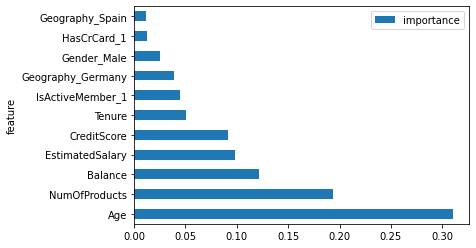

In [24]:
importances = best_model_balance_rf.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).\
reset_index(drop=True)
display(feature_results.head(10))
feature_results.plot(kind='barh', x='feature')
plt.show()

<div>
    <font color='green'>AUC-ROC для модели случайного леса с взвешиванием классов</font>
</div>

In [25]:
probabilities_valid = best_model_balance_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)# < напишите код здесь >

print(auc_roc)

0.8424427782162589


<div>
    <font color='green'>Модель логистической ргрессии с взвешиваием классов</font>
</div>

In [26]:
model_balance_lr = LogisticRegression(random_state=12345, solver='liblinear',\
                                      class_weight='balanced')

model_balance_lr.fit(features_train, target_train)
predictions = model_balance_lr.predict(features_valid) 
result_balance_lr = f1_score(target_valid, predictions)

print('f1 модели:', result_balance_lr)

f1 модели: 0.5087040618955513


<div>
    <font color='green'>AUC-ROC для модели логистической регрессии с взвешиванием классов</font>
</div>

In [27]:
probabilities_valid = model_balance_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.778158553111644


In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
target_upsampled.value_counts()

1    4448
0    4342
Name: Exited, dtype: int64

<div>
    <font color='green'>Модель решающего дерева с увеличением выборки</font>
</div>

100%|██████████| 39/39 [00:01<00:00, 24.63it/s]


max_depth лучшей модели: 8
f1 лучшей модели: 0.5711060948081264


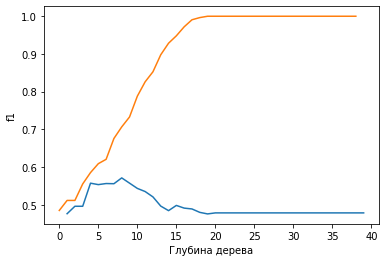

In [29]:

best_model_upsampling_dt = None
best_result_upsampling_dt = 0
result_dt_upsampling_plot = []
result_dt_upsampling_plot_train = []
for depth_dt in tqdm(range(1, 40)):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth_dt) 
    model_dt.fit(features_upsampled, target_upsampled) 
    predictions = model_dt.predict(features_valid) 
    result_dt = f1_score(target_valid, predictions) 
    result_dt_upsampling_plot.append(result_dt)
    predictions_train = model_dt.predict(features_train) 
    result_dt_train = f1_score(target_train, predictions_train) 
    result_dt_upsampling_plot_train.append(result_dt_train)
    if result_dt > best_result_upsampling_dt:
        best_model_upsampling_dt = model_dt
        best_result_upsampling_dt = result_dt
        best_depth_upsampling_dt = depth_dt

print('max_depth лучшей модели:', best_depth_upsampling_dt)
print("f1 лучшей модели:", best_result_upsampling_dt)

plt.plot(range(1,40), result_dt_upsampling_plot, result_dt_upsampling_plot_train)
plt.xlabel('Глубина дерева')
plt.ylabel('f1')
plt.show()

,feature,importance
0,Age,0.363764
1,NumOfProducts,0.258921
2,Balance,0.139867
3,EstimatedSalary,0.056622
4,CreditScore,0.050680
5,IsActiveMember_1,0.048779
6,Geography_Germany,0.032006
7,Tenure,0.021648
8,Gender_Male,0.020934
9,HasCrCard_1,0.005411


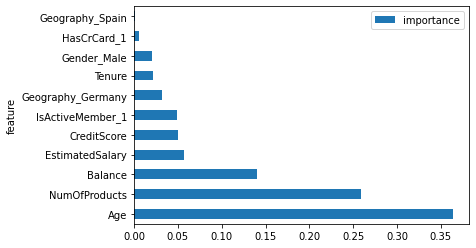

In [30]:
importances = best_model_upsampling_dt.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).\
reset_index(drop=True)
display(feature_results.head(10))
feature_results.plot(kind='barh', x='feature')
plt.show()

<div>
    <font color='green'>AUC-ROC для модели решающего дерева с увеличением выборки</font>
</div>

In [31]:
probabilities_valid = best_model_upsampling_dt.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)# < напишите код здесь >

print(auc_roc)

0.8081106387097735


<div>
    <font color='green'>Модель случайного леса с увеличением выборки</font>
</div>

In [32]:

best_model_upsampling_rf = None
best_result_upsampling_rf = 0
for depth_rf in tqdm(range(1, 20)):
    model_rf = RandomForestClassifier(random_state=12345, n_estimators=60, \
                                      max_depth=depth_rf)  
    model_rf.fit(features_upsampled, target_upsampled)
    predictions = model_rf.predict(features_valid) 
    result_rf = f1_score(target_valid, predictions)  
    if result_rf > best_result_upsampling_rf:
        best_model_upsampling_rf = model_rf
        best_result_upsampling_rf = result_rf
        best_depth_upsampling_rf = depth_rf
print('max_depth лучшей модели:', best_depth_upsampling_rf)
print("f1 наилучшей модели на валидационной выборке:", best_result_upsampling_rf)

100%|██████████| 19/19 [00:09<00:00,  2.09it/s]

max_depth лучшей модели: 15
f1 наилучшей модели на валидационной выборке: 0.6127167630057804


,feature,importance
0,Age,0.260928
1,Balance,0.144473
2,NumOfProducts,0.139892
3,CreditScore,0.132074
4,EstimatedSalary,0.128864
5,Tenure,0.076218
6,IsActiveMember_1,0.035676
7,Geography_Germany,0.030254
8,Gender_Male,0.020708
9,HasCrCard_1,0.017748


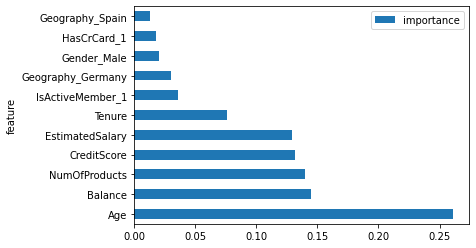

In [33]:
importances = best_model_upsampling_rf.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).\
reset_index(drop=True)
display(feature_results.head(10))
feature_results.plot(kind='barh', x='feature')
plt.show()

<div>
    <font color='green'>AUC-ROC для модели случайного леса с увеличением выборки</font>
</div>

In [34]:
probabilities_valid = best_model_upsampling_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)# < напишите код здесь >

print(auc_roc)

0.8385764917871662


<div>
    <font color='green'>Модель логистической регрессии с увеличением выборки</font>
</div>

In [35]:
model_upsampling_lr = LogisticRegression(random_state=12345, solver='liblinear')

model_upsampling_lr.fit(features_upsampled, target_upsampled)
predictions = model_upsampling_lr.predict(features_valid) 
result_upsampling_lr = f1_score(target_valid, predictions)

print('f1 модели:', result_upsampling_lr)

f1 модели: 0.5042816365366317


<div>
    <font color='green'>AUC-ROC для модели логистической регрессии с увеличением выборки</font>
</div>

In [36]:
probabilities_valid = model_upsampling_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.7781846137808819


In [37]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

fraction = target_train.value_counts()[1]/target_train.value_counts()[0]
features_downsampled, target_downsampled = downsample(features_train, target_train, fraction)
target_downsampled.value_counts()

0    1112
1    1112
Name: Exited, dtype: int64

<div>
    <font color='green'>Модель решающего дерева с уменьшением выборки</font>
</div>

100%|██████████| 39/39 [00:00<00:00, 50.46it/s]


max_depth лучшей модели: 5
f1 лучшей модели: 0.5582761998041136


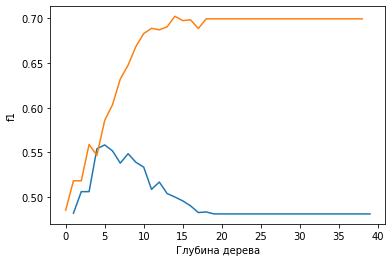

In [38]:
best_model_downsampling_dt = None
best_result_downsampling_dt = 0
result_dt_downsampling_plot = []
result_dt_downsampling_plot_train = []
for depth_dt in tqdm(range(1, 40)):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth_dt) 
    model_dt.fit(features_downsampled, target_downsampled) 
    predictions = model_dt.predict(features_valid) 
    result_dt = f1_score(target_valid, predictions) 
    result_dt_downsampling_plot.append(result_dt)
    predictions_train = model_dt.predict(features_train) 
    result_dt_train = f1_score(target_train, predictions_train) 
    result_dt_downsampling_plot_train.append(result_dt_train)
    if result_dt > best_result_downsampling_dt:
        best_model_downsampling_dt = model_dt
        best_result_downsampling_dt = result_dt
        best_depth_downsampling_dt = depth_dt

print('max_depth лучшей модели:', best_depth_downsampling_dt)
print("f1 лучшей модели:", best_result_downsampling_dt)

plt.plot(range(1,40), result_dt_downsampling_plot, result_dt_downsampling_plot_train)
plt.xlabel('Глубина дерева')
plt.ylabel('f1')
plt.show()

,feature,importance
0,Age,0.457367
1,NumOfProducts,0.375260
2,IsActiveMember_1,0.062454
3,Geography_Germany,0.044102
4,Balance,0.043702
5,Gender_Male,0.006844
6,EstimatedSalary,0.004771
7,CreditScore,0.003114
8,Tenure,0.002386
9,Geography_Spain,0.000000


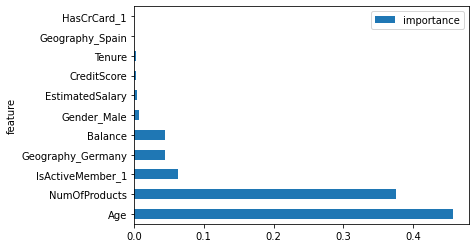

In [39]:
importances = best_model_downsampling_dt.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).\
reset_index(drop=True)
display(feature_results.head(10))
feature_results.plot(kind='barh', x='feature')
plt.show()

<div>
    <font color='green'>AUC-ROC для модели решающего дерева с уменьшением выборки</font>
</div>

In [40]:
probabilities_valid = best_model_downsampling_dt.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)# < напишите код здесь >

print(auc_roc)

0.8335216526931839


<div>
    <font color='green'>Модель случайного леса с уменьшением выборки</font>
</div>

In [41]:

best_model_downsampling_rf = None
best_result_downsampling_rf = 0
for depth_rf in tqdm(range(1, 20)):
    model_rf = RandomForestClassifier(random_state=12345, n_estimators=60, \
                                      max_depth=depth_rf)  
    model_rf.fit(features_downsampled, target_downsampled)
    predictions = model_rf.predict(features_valid) 
    result_rf = f1_score(target_valid, predictions)  
    if result_rf > best_result_downsampling_rf:
        best_model_downsampling_rf = model_rf
        best_result_downsampling_rf = result_rf
        best_depth_downsampling_rf = depth_rf
print('max_depth лучшей модели:', best_depth_downsampling_rf)
print("f1 наилучшей модели на валидационной выборке:", best_result_downsampling_rf)

100%|██████████| 19/19 [00:04<00:00,  4.50it/s]

max_depth лучшей модели: 7
f1 наилучшей модели на валидационной выборке: 0.5902004454342984


,feature,importance
0,Age,0.350848
1,NumOfProducts,0.229154
2,Balance,0.104579
3,EstimatedSalary,0.063394
4,CreditScore,0.060714
5,IsActiveMember_1,0.057367
6,Geography_Germany,0.056022
7,Tenure,0.035833
8,Gender_Male,0.025540
9,Geography_Spain,0.008971


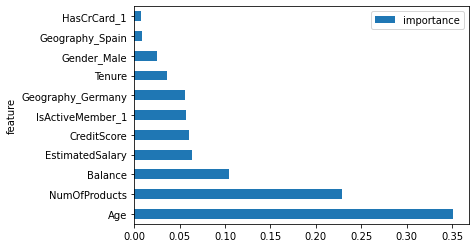

In [42]:
importances = best_model_downsampling_rf.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).\
reset_index(drop=True)
display(feature_results.head(10))
feature_results.plot(kind='barh', x='feature')
plt.show()

<div>
    <font color='green'>AUC-ROC для модели случайного леса с уменьшением выборки</font>
</div>

In [43]:
probabilities_valid = best_model_downsampling_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)# < напишите код здесь >

print(auc_roc)

0.8526008547899511


<div>
    <font color='green'>Модель логистической регрессии с уменьшением выборки</font>
</div>

In [44]:
model_downsampling_lr = LogisticRegression(random_state=12345, solver='liblinear')

model_downsampling_lr.fit(features_downsampled, target_downsampled)
predictions = model_downsampling_lr.predict(features_valid) 
result_downsampling_lr = f1_score(target_valid, predictions)

print('f1 модели:', result_downsampling_lr)

f1 модели: 0.5062082139446037


<div>
    <font color='green'>AUC-ROC для модели логистической регрессии с уменьшением выборки</font>
</div>

In [45]:
probabilities_valid = model_downsampling_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)# < напишите код здесь >

print(auc_roc)

0.7793740971839584


Вывод:\
\
Лучшим результатом f1-меры является значение f1=0.6171107994389902 у модели случайного леса со взвешиванием классов при глубине деревьев равной 10 и колличеством деревьев равным 20. В целом результаты лучше, чем при дисбалансе. Самыми важными признаками для обучения являются Age, NumOfProducts. AUC-ROC у некоторых моделей достигает 0.85.

## Тестирование модели

<div>
    <font color='green'>Тестирование модели случайного леса с глубиной деревьев равной 10 и колличеством деревьев равым 20 со взвешиванием классов.</div>

In [46]:
features_train_valid = pd.concat([features_train]+[features_valid])
target_train_valid = pd.concat([target_train]+[target_valid])
features_train_valid, target_train_valid = shuffle(features_train_valid, \
                                                   target_train_valid, random_state=12345)
best_model_balance_rf.fit(features_train_valid, target_train_valid)
predictions = best_model_balance_rf.predict(features_test)

result = f1_score(target_test, predictions)
    

print('f1 лучшей модели на тестовой выборке:', result)

f1 лучшей модели на тестовой выборке: 0.606516290726817


<div>
    <font color='green'>AUC-ROC данной модели</div>

In [47]:
probabilities_test = best_model_balance_rf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print(auc_roc)

0.8623828089345557


Вывод:\
\
Были рассмотренны модели с дисбалансом и с борьбой с дисбалансом. При уменьшении дисбаланса результаты оказались лучше как у f1 меры, так и у AUC-ROC.\
\
Самым высоким значением f1 меры вышло значение f1=0.6171107994389902 у модели случайного леса со взвешиванием классов при глубине деревьев равной 10 и колличеством деревьев равным 20. AUC-ROC при этом получилось равным 0.8424427782162589, что не является самым высоким значением среди всех результатов. С худшими результатами метрик получились модели логистической регрессии как с дисбалансом, так и с борьбой с дисбалансом.\
\
Были выявлены самые значимые для обучения признаки для каждого случая. Во всех случаях самым значимым вышел признак Age. В случаях данных с уменьшенным дисбалансом также общими по значимости оказался признак NumOfProducts.\
\
Значение AUC-ROC в случае с дисбалансом примерно равно 0.8. При уменьшении дисбаланса результат немного выше и достигает 0.85.\
\
На тестовой выборке использовалась модель случайного леса с глубиной деревьев равной 10 и колличестовом деревьев равным 20 со взвешиванием классов. Также для улучшения результата тестирование проводилось на сумме тренировочных данных с валлидационными данными. f1 мера получилось равной 0.606516290726817. AUC-ROC при этом равно 0.8623828089345557.